In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import auto_arima

rcParams['figure.figsize'] = 15,6


In [8]:
##Preprossing Data
filepath = 'Datasets/owid-covid-data.csv'
dateparse = lambda date: pd.to_datetime(date, format = '%Y-%m-%d')
data = pd.read_csv(filepath, parse_dates = ['date'], index_col = 'date', date_parser = dateparse)
#separando o dataset
df_mundo = data[data.location == 'World'].copy()
df = df_mundo['new_cases'].copy()
#df_continentes = df[(df.continent.isna()) & (df.location != 'World')].copy()

/tmp/ipykernel_12471/2924266280.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(filepath, parse_dates = ['date'], index_col = 'date', date_parser = dateparse)


In [9]:
df.index.freq = 'D'

In [10]:
display(df)

date
2020-01-22         0.0
2020-01-23        98.0
2020-01-24       286.0
2020-01-25       492.0
2020-01-26       685.0
                ...   
2021-07-13    520038.0
2021-07-14    540104.0
2021-07-15    569347.0
2021-07-16    599949.0
2021-07-17    472593.0
Freq: D, Name: new_cases, Length: 543, dtype: float64

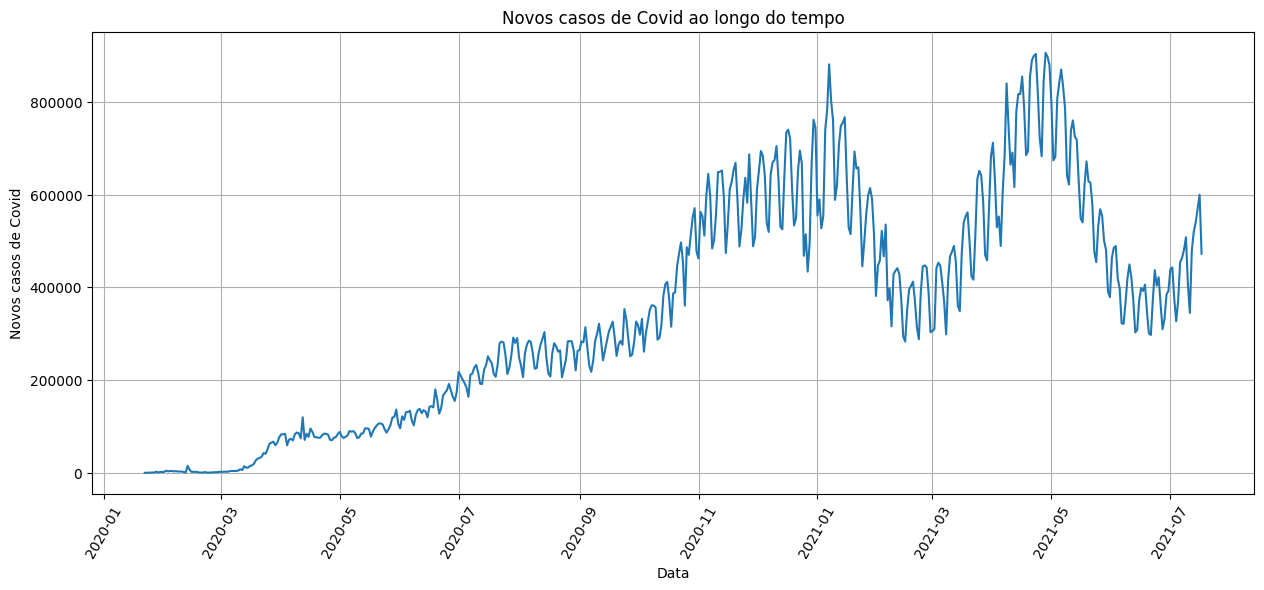

In [11]:
##Ploting Data
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from pandas.plotting import register_matplotlib_converters
rcParams['figure.figsize'] = 15, 6
plt.plot(df)
plt.title("Novos casos de Covid ao longo do tempo")
plt.xlabel("Data")
plt.ylabel("Novos casos de Covid")
plt.xticks(rotation =60)
plt.grid(True)
plt.show()


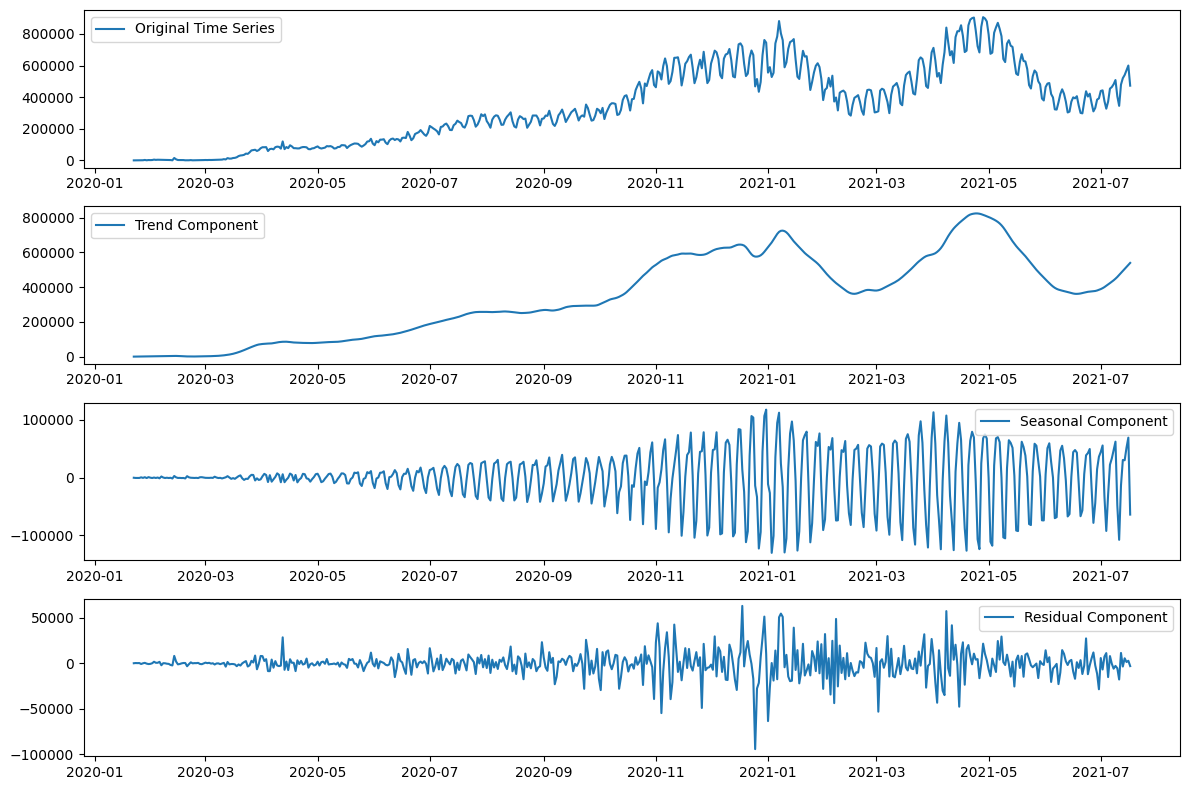

In [12]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

## DADOS COMPLETOS
# Assuming 'df' is your DataFrame with a 'value' column
stl = STL(df_mundo.new_cases) # Adjust 'seasonal' parameter based on your
result = stl.fit()
# Extract components
df.trend = result.trend
df.seasonal = result.seasonal
df.residual = result.resid
# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(df.trend, label='Trend Component')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(df.seasonal, label='Seasonal Component')
plt.legend(loc='upper right')
plt.subplot(414)
plt.plot(df.residual, label='Residual Component')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


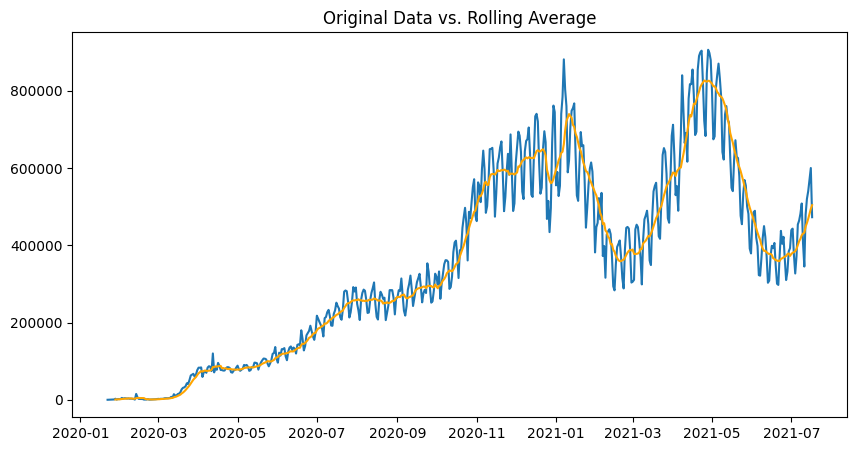

In [13]:
# Calculating a 12-month rolling average
df.mean = df.rolling(window=7).mean()
plt.figure(figsize=(10, 5))
plt.plot(df, label='Original Data')
plt.plot(df.mean, label='12-Month Rolling Average', color='orange')
plt.title('Original Data vs. Rolling Average')
plt.show()


In [14]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return result[1] # Return the p-value

p_value = check_stationarity(df.mean.dropna())
if p_value <= 0.05:
    print(f" The series 'new_cases' is likely stationary")
else:
    print(f" The series 'new_cases' is likely non-stationary")
print(p_value)

 The series 'new_cases' is likely non-stationary
0.29708196252995234


In [15]:
from numpy import log
df.mean_diff = df.mean.diff().dropna()
df.mean_diff_sazonal = df.mean.diff(periods = 7).dropna()
#df_mundo['new_cases_log'] = log(df_mundo['new_cases'])

In [16]:
p_value = check_stationarity(df.mean_diff.dropna())
if p_value <= 0.05:
     print(f" The series 'mean_diff' is likely stationary")
else:
    print(f" The series 'mean_diff' is likely non-stationary")
print(p_value)

 The series 'mean_diff' is likely stationary
0.008935438610903219


In [17]:
p_value = check_stationarity(df.mean_diff_sazonal.dropna())
if p_value <= 0.05:
     print(f" The series 'mean_diff_sanzonal' is likely stationary")
else:
    print(f" The series 'mean_diff_sanzonal' is likely non-stationary")
print(p_value)

 The series 'mean_diff_sanzonal' is likely stationary
0.0114307630395368


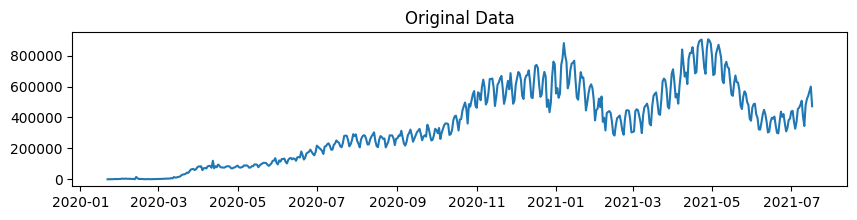

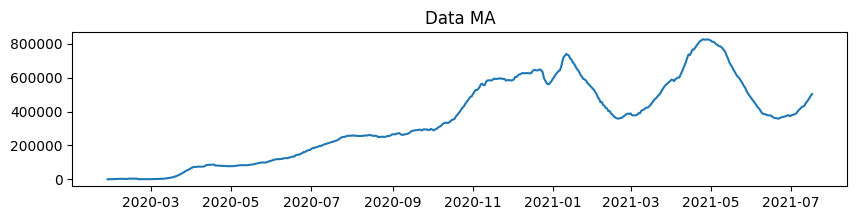

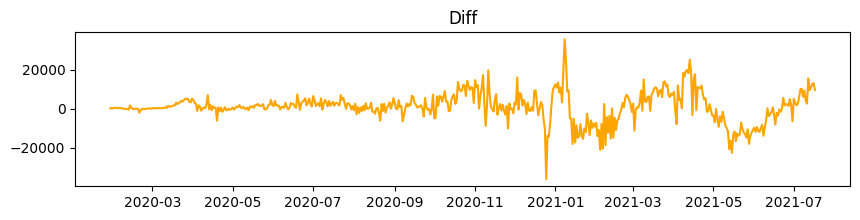

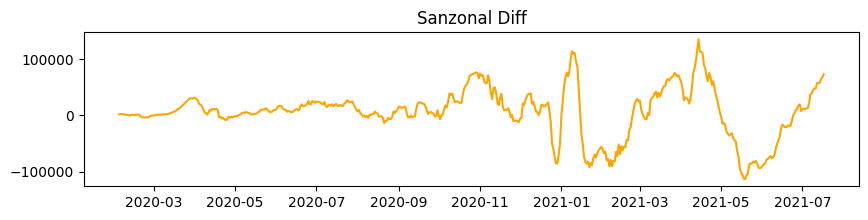

In [18]:
plt.figure(figsize=(10, 2))
plt.plot(df, label='Original Data')
plt.title('Original Data')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df.mean, label='Data MA')
plt.title('Data MA')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df.mean_diff, label='Diff', color='orange')
plt.title('Diff')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(df.mean_diff_sazonal, label='Sanzonal', color='orange')
plt.title('Sanzonal Diff')
plt.show()

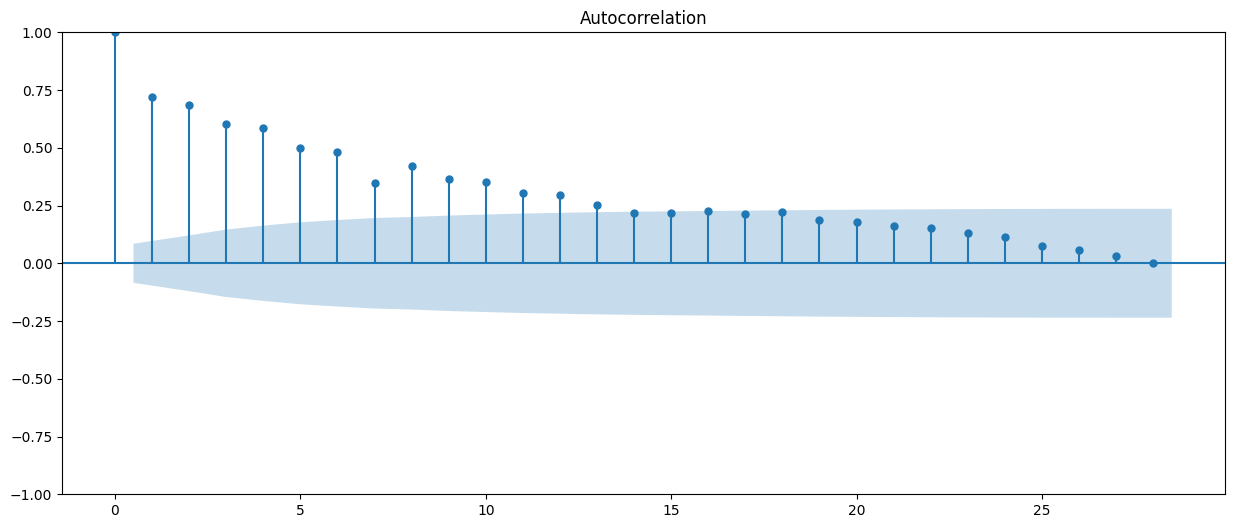

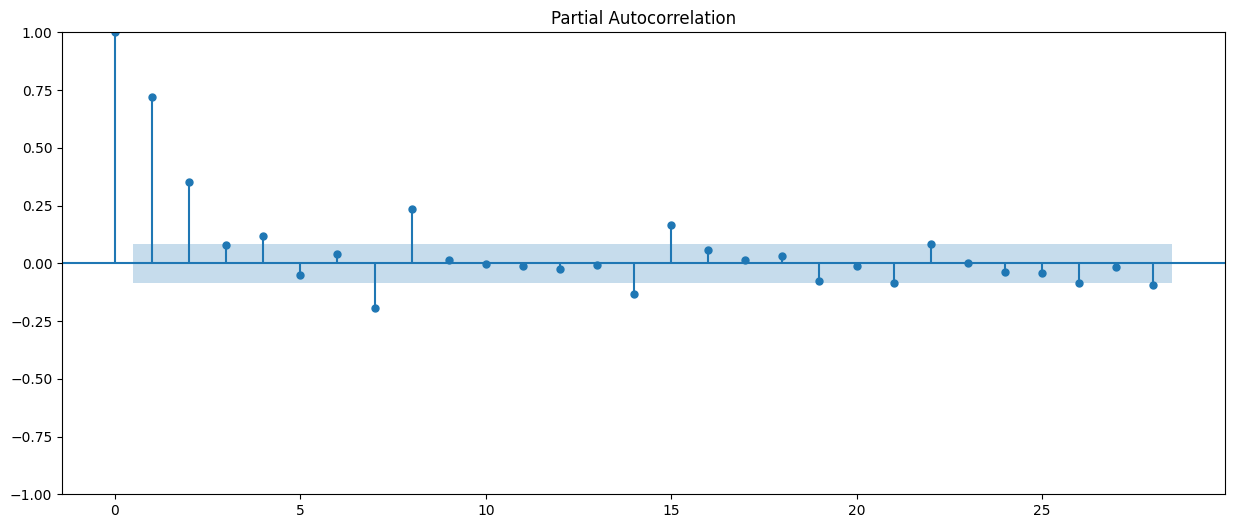

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.mean_diff)
plot_pacf(df.mean_diff,method = 'ywm')
plt.show()


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  214
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1892.100
Date:                Fri, 11 Oct 2024   AIC                           3794.199
Time:                        14:22:30   BIC                           3811.029
Sample:                    01-29-2020   HQIC                          3801.000
                         - 08-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1191.9773    359.349      3.317      0.001     487.667    1896.288
ar.L1          0.2147      0.059      3.630      0.000       0.099       0.331
ar.L2          0.2813      0.066      4.252      0.0

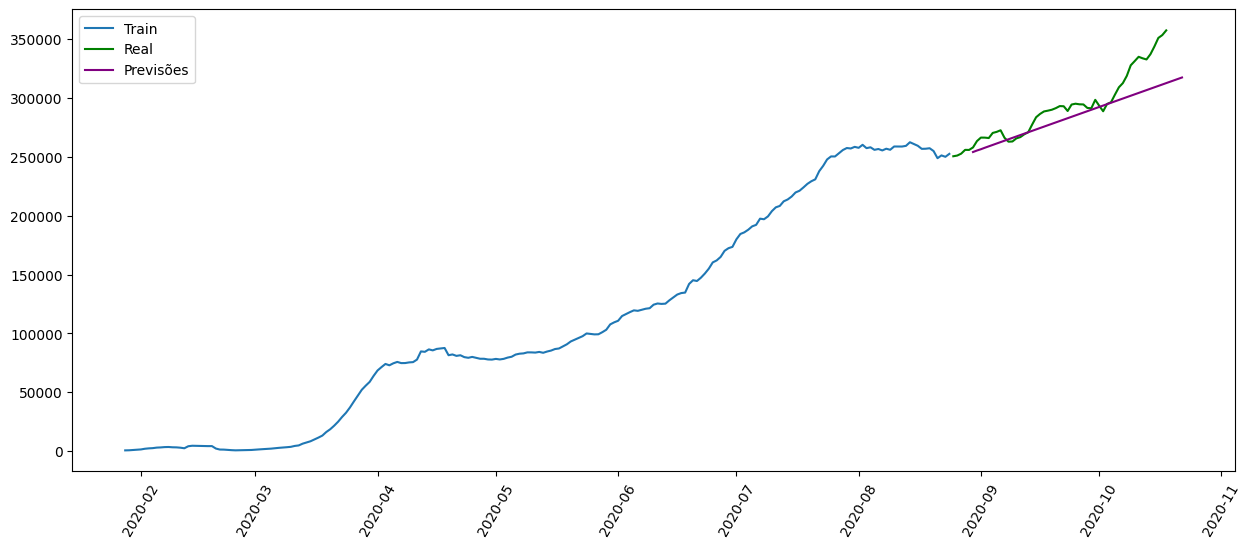

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

X = df.mean_diff
X_real = df.mean
'''
X = df.mean_diff[:int(len(df.mean_diff)*0.5)].copy()
X_real = df.mean[:int(len(df.mean)*0.5)].copy()
'''
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
X_test_real = X_real[int(len(X_real)*0.8):]
X_train_real = X_real[:int(len(X_real)*0.8)]
p,d,q = 3,0,0


model = ARIMA(X_train,order = (p,d,q))
model_fit = model.fit()
print(model_fit.summary())
previsoes = model_fit.forecast(steps=len(X_test))

from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(X_test, previsoes))
print(f'RMSE: {rmse}')

# Visualizar as previsões
'''
plt.plot(X_test, label='Real')
plt.plot(previsoes, color='red', label='Previsões')
plt.xticks(rotation =60)
plt.show()
'''
first_value = X_train_real.iloc[-1]
reverse_diff = previsoes.cumsum() + first_value

plt.plot(X_train_real, label= 'Train')
plt.plot(X_test_real, color = 'green', label='Real')
plt.plot(reverse_diff, color='purple', label='Previsões')
plt.xticks(rotation =60)
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

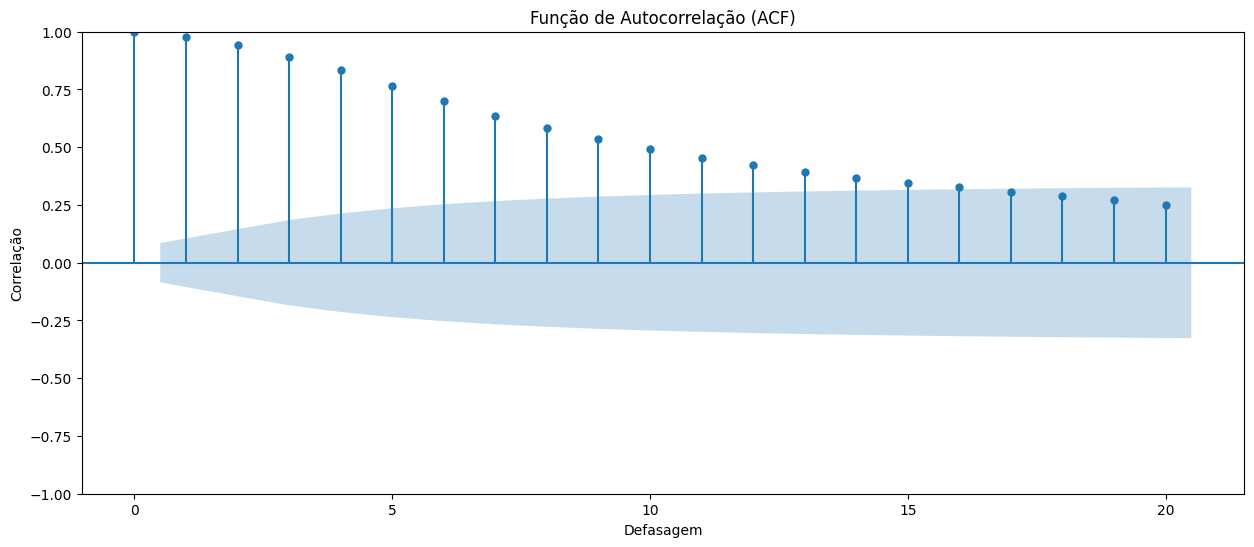

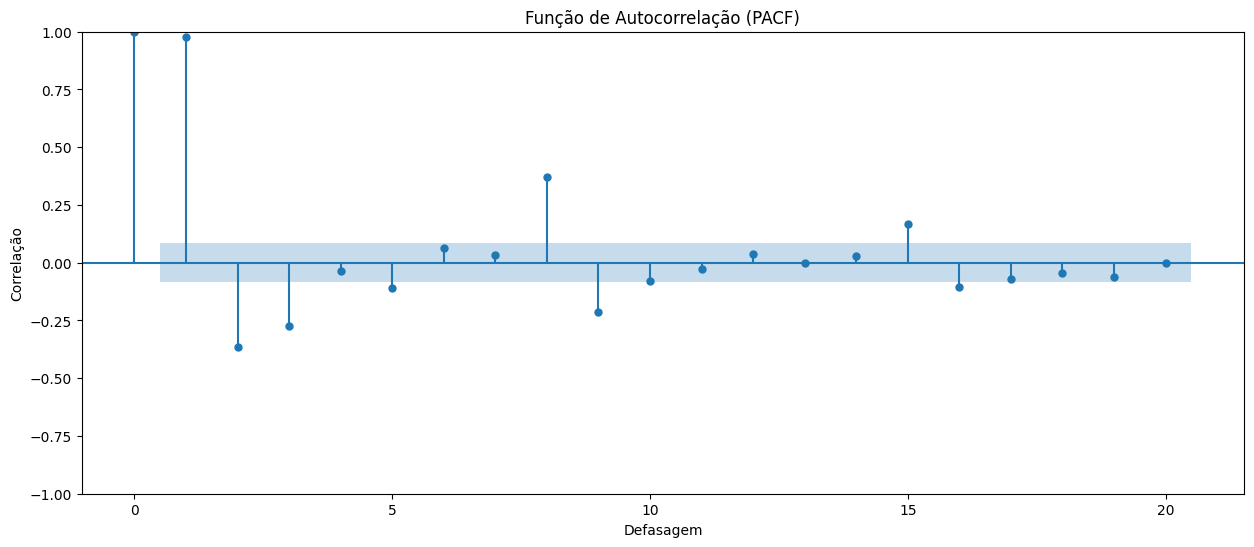

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Verificar e garantir que a série temporal não tenha valores ausentes
df.mean_diff_sazonal = df.mean_diff_sazonal.dropna()
# Plotar ACF
plt.figure(figsize=(10, 6))
plot_acf(df.mean_diff_sazonal.dropna(), lags=20, alpha=0.05, use_vlines=True)
plt.title('Função de Autocorrelação (ACF)')
plt.xlabel('Defasagem')
plt.ylabel('Correlação')
plt.show()

plot_pacf(df.mean_diff_sazonal.dropna(), lags=20, alpha=0.05, use_vlines=True)
plt.title('Função de Autocorrelação (PACF)')
plt.xlabel('Defasagem')
plt.ylabel('Correlação')
plt.show()

In [29]:
from statsmodels.tsa.arima.model import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

X = df.mean_diff[:int(len(df.mean_diff)*0.5)].copy()
X_real = df.mean[:int(len(df.mean)*0.5)].copy()

X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
X_test_real = X_real[int(len(X_real)*0.8):]
X_train_real = X_real[:int(len(X_real)*0.8)]
p,d,q = 3,0,0


model = SARIMAX(X_train,order = (p,d,q), seasonal = (3,0,0,120))
model_fit = model.fit()
print(model_fit.summary())
previsoes = model_fit.forecast(steps=len(X_test))

from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(X_test, previsoes))
print(f'RMSE: {rmse}')

# Visualizar as previsões
'''
plt.plot(X_test, label='Real')
plt.plot(previsoes, color='red', label='Previsões')
plt.xticks(rotation =60)
plt.show()
'''
first_value = X_train_real.iloc[-1]
reverse_diff = previsoes.cumsum() + first_value

plt.plot(X_train_real, label= 'Train')
plt.plot(X_test_real, color = 'green', label='Real')
plt.plot(reverse_diff, color='purple', label='Previsões')
plt.xticks(rotation =60)
plt.legend()
plt.show()

ImportError: cannot import name 'SARIMAX' from 'statsmodels.tsa.arima.model' (/home/ismael/tf-demo/tensorflow-dev/lib/python3.11/site-packages/statsmodels/tsa/arima/model.py)

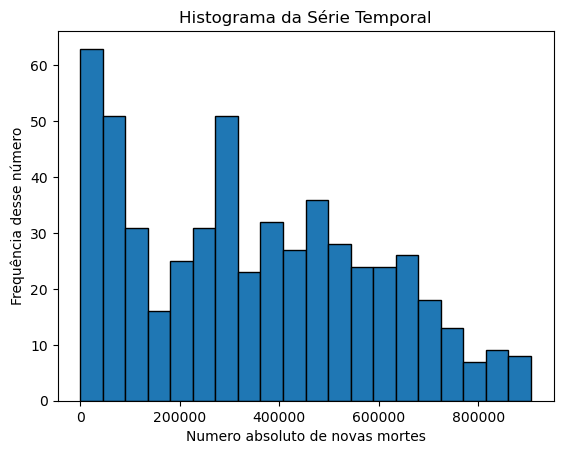

In [32]:
plt.hist(df_mundo['new_cases'], bins=20, edgecolor='black')
plt.title('Histograma da Série Temporal')
plt.xlabel('Numero absoluto de novas mortes')
plt.ylabel('Frequência desse número')
plt.show()

In [34]:
stepwise_model = auto_arima(df.mean_diff, start_p = 3, d = 0, start_q = 0, seasonal = False, error_action = 'ignore', stepwise = True)

In [57]:
train = df.mean_diff.loc[:'2021-05-01']
train_real = df.mean.loc[:'2021-05-01']
test = df.mean_diff.loc['2021-05-02':]
real_test = df.mean.loc['2021-05-02':]
stepwise_model.fit(train)

ARIMA(order=(4, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [50]:
f_forecast = stepwise_model.predict(n_periods = 75)

In [54]:
f_forecast = pd.DataFrame(f_forecast, index = test.index, columns = ['new_cases'])
first_value = train_real.iloc[-1]
reverse_diff = f_forecast.cumsum() + first_value



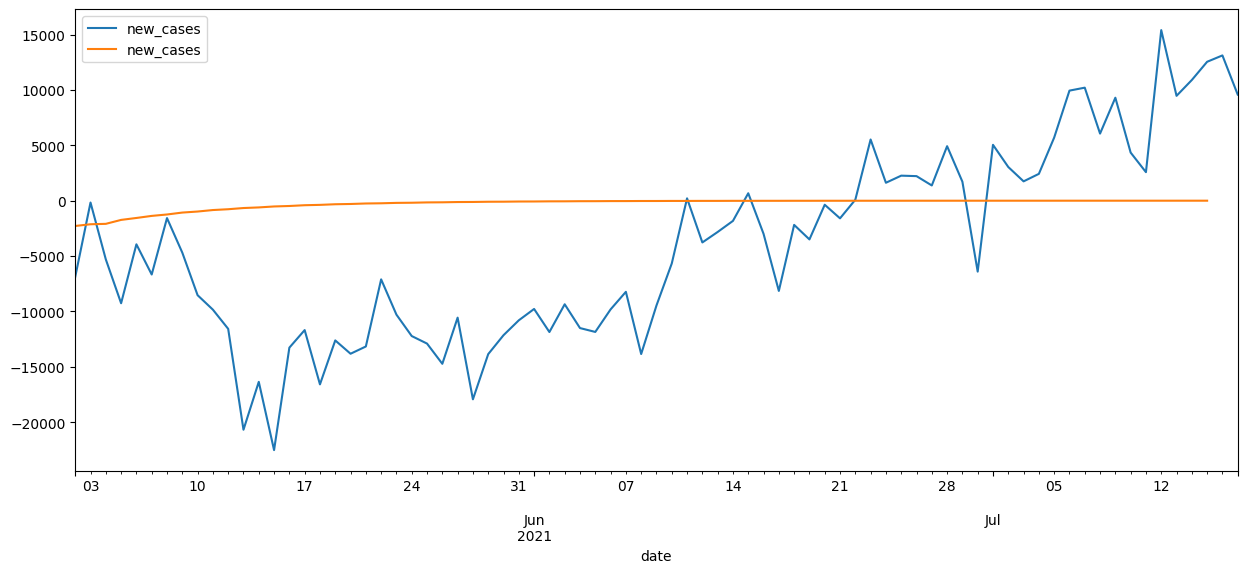

In [52]:
pd.concat([test,f_forecast], axis = 1).plot()
plt.show()

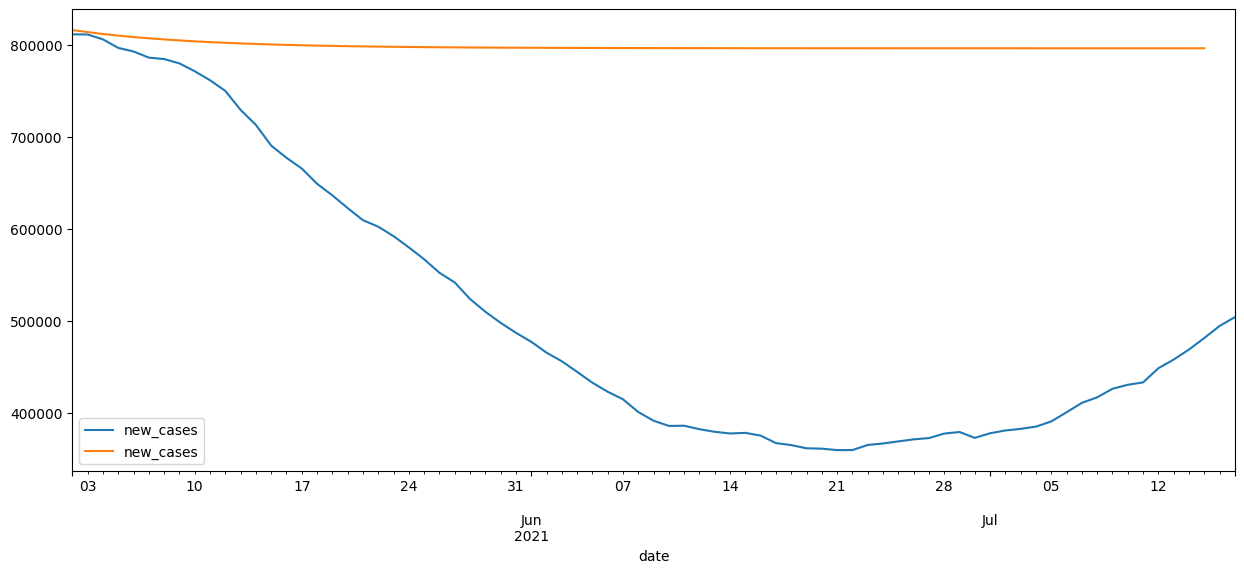

In [58]:
pd.concat([real_test,reverse_diff], axis = 1).plot()
plt.show()

In [ ]:
pd.concat([test,f_forecast], axis = 1).plot()